# Generating complex densities using Diffusion models

1. moving to alphabets and number generation using diffusion models
    * We will be using JAX
    * Using U-net blocks for modelling the denoising process

In [1]:
!pip install einops
!pip install dm-tree graphviz

In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import einops
import math
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
jax.config.update('jax_platform_name', 'cpu')
Batch = Tuple[np.ndarray, np.ndarray]

2022-11-27 00:29:23.266855: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 00:29:23.825590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-11-27 00:29:23.825680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2022-11-27 00:29:23.825688: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned abo

In [3]:
# upsample operation in the UNET
class Downsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(4, 4), stride=2, padding=[1, 1])
  
  def __call__(self, x):
    return jax.nn.relu(self.conv(x))
  
# Downsample operation in the UNET
class Upsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(3, 3), padding='SAME')
  
  def __call__(self, x):
    x = einops.repeat(x, 'b h w c -> b (a h) (aa w) c', a=2, aa=2)
    return jax.nn.relu(self.conv(x))
      
class TimeEmbeddings(hk.Module):
  def __init__(self, dim):
    super().__init__()
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    self.embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)

  def __call__(self, timesteps):
      embeddings = self.embeddings
      embeddings = jnp.multiply(timesteps[:, None], embeddings[:, None].T)
      embeddings = jnp.hstack([jnp.sin(embeddings), jnp.cos(embeddings)])
      return embeddings

class Block(hk.Module):
  # a basic resnet style convolutional block
  def __init__(self, output_channels, kernel_size, padding, time_dim=None):
    super().__init__()
    self.seq = hk.Sequential([
      hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME'),
      jax.nn.relu,
      hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME'),
      jax.nn.relu,
    ])
    self.time_mlp = None
    if time_dim is not None:
      self.h, self.w, self.c = time_dim
      dims = self.h*self.w*self.c
      self.time_mlp = hk.Sequential([
        TimeEmbeddings(dims),
        hk.Linear(dims*2),
        jax.nn.selu
      ])
    
  def __call__(self, x, timesteps=None):
    if timesteps is not None and self.time_mlp is not None:
      time_embedding = self.time_mlp(timesteps)
      time_embedding = einops.rearrange(time_embedding, 'b (h w c) -> b h w c', h=self.h, w=self.w)
      shift, scale = jnp.split(time_embedding, indices_or_sections=2, axis=-1)
      x = shift + scale*x
    
    h = self.seq(x)
    return x + h

In [4]:
# Unet class to predict noise from a given image
class UNet(hk.Module):
  def __init__(self):
    super().__init__()
    self.init_conv = hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME')
    self.relu1 = jax.nn.relu
    self.block1 = Block(output_channels=16, kernel_size=3, padding=1, time_dim=(28, 28, 1))
    self.downsample1 = Downsample(32)
    self.block2 = Block(output_channels=32, kernel_size=3, padding=1, time_dim=None)
    self.downsample2 = Downsample(64)
    self.middle_block = Block(output_channels=64, kernel_size=3, padding=1, time_dim=None)
    self.upsample1 = Upsample(32)
    self.block3 = Block(output_channels=32, kernel_size=3, padding=1, time_dim=None)
    self.upsample2 = Upsample(16)
    self.block4 = Block(output_channels=16, kernel_size=3, padding=1, time_dim=None)
    self.out_conv = hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME')
      
  def __call__(self, x, timesteps):
    h = self.relu1(self.init_conv(x))
    h = self.downsample1(self.block1(h, timesteps))
    h = self.downsample2(self.block2(h, timesteps))
    h = self.upsample1(self.middle_block(h, timesteps))
    h = self.upsample2(self.block3(h, timesteps))
    h = self.block4(h, timesteps)
    h = self.out_conv(h)
    return h

In [5]:
import graphviz

def f(x, timesteps):
  unet = UNet()
  return unet(x, timesteps)

f_t = hk.transform(f)

x = jnp.ones([1, 28, 28, 1])
timesteps_ = jnp.arange(0, 1)

rng = jax.random.PRNGKey(42)
params = f_t.init(rng, x, timesteps_)

# dot = hk.experimental.to_dot(f_t.apply)(params, None, x, timesteps)
# graphviz.Source(dot)

# print(hk.experimental.tabulate(f_t)(x, timesteps_))

In [6]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
generate_new_data = True
train_new_model = True

In [8]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = jnp.linspace(0, timesteps, steps)
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0.0001, 0.05)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = jnp.linspace(-6, 6, timesteps)
    return jnp.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [9]:
# Train model
timesteps = 1000
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = jnp.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = jnp.sqrt(variance)

alphas_prev_ = jnp.pad(alphas_[:-1], [1, 0], "constant", constant_values=1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = jnp.log(1-alphas) + jnp.log(1-alphas_) - jnp.log(1-alphas_prev_)
sigma_squared_q_t_corrected = jnp.exp(log_sigma_squared_q_t)

# how to add noise to the data
# @jax.jit
def get_noisy(batch, timestep):
    # we will use the reparameterization trick
    key = jax.random.PRNGKey(42)
    # need to generate new keys everytime
    noise_at_t = jax.random.normal(key, shape=batch.shape)
    added_noise_at_t = jnp.add(batch * alphas_[timestep], noise_at_t * sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = (batch.sub(noise.mul(sd[timestep]))).div(alphas_[timestep])
    return true_data

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = jnp.exp(log_posterior_variance)

([<matplotlib.lines.Line2D at 0x7fb21c731810>],
 [<matplotlib.lines.Line2D at 0x7fb21e78df00>])

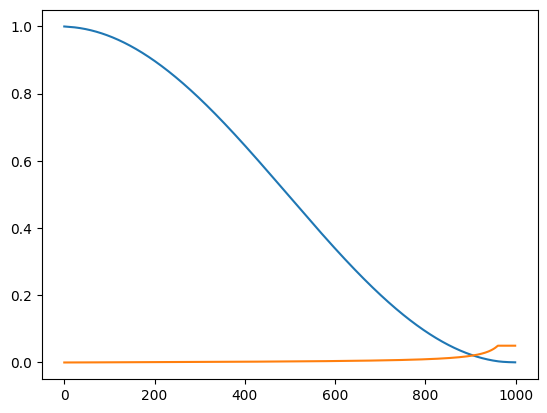

In [10]:
plt.plot(alphas_), plt.plot(posterior_variance_corrected)



---




In [11]:
EMNIST_MEAN = (0.13066373765468597)
EMNIST_STD = (0.30810782313346863)

# adapted from Optax loss -- https://github.com/deepmind/optax/blob/master/optax/_src/loss.py
def huber_loss(
    predictions,
    targets= None,
    delta= 1.):
  """Huber loss, similar to L2 loss close to zero, L1 loss away from zero.
  If gradient descent is applied to the `huber loss`, it is equivalent to
  clipping gradients of an `l2_loss` to `[-delta, delta]` in the backward pass.
  References:
    [Huber, 1964](www.projecteuclid.org/download/pdf_1/euclid.aoms/1177703732)
  Args:
    predictions: a vector of arbitrary shape `[...]`.
    targets: a vector with shape broadcastable to that of `predictions`;
      if not provided then it is assumed to be a vector of zeros.
    delta: the bounds for the huber loss transformation, defaults at 1.
  Returns:
    elementwise huber losses, with the same shape of `predictions`.
  """
  errors = (predictions - targets) if (targets is not None) else predictions
  # 0.5 * err^2                  if |err| <= d
  # 0.5 * d^2 + d * (|err| - d)  if |err| > d
  abs_errors = jnp.abs(errors)
  quadratic = jnp.minimum(abs_errors, delta)
  # Same as max(abs_x - delta, 0) but avoids potentially doubling gradient.
  linear = abs_errors - quadratic
  return jnp.sum(0.5 * quadratic ** 2 + delta * linear, axis=(1, 2, 3))

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """Loads the dataset as a generator of batches."""
  # cache the dataset to memory and repeat it indefinitely, epochs have reshuffled ordered data since *reshuffle_each_iteration* defaults to TRUE
  ds = tfds.load('emnist', split=split, as_supervised=True).cache().repeat()
  if is_training:
    # shuffle the batches to improve generalization of the trained network
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

# Recommended: this can be jit'd and it should result in faster training time 
# @jax.jit
def compute_loss(params: hk.Params, batch: Batch, is_energy_method: bool=False) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  x, _, timestep, noise = batch
  pred_data = net.apply(params, x, timestep)
  if not is_energy_method:
      imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep]))
      # loss on prediction
      loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(noise, pred_data)))
  else:
      ## Energy function interpretation
      imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep]))
      # loss on prediction
      loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(pred_data, jnp.divide(noise, -sd[timestamp]))))
  return loss_ 

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  """Compute gradients and update the weights"""
  loss_value, grads = jax.value_and_grad(compute_loss)(params, batch)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss_value, new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.001)


def normalize(images):
  # numpy array creation could be moved out of the method
  mean = np.asarray(EMNIST_MEAN)
  std = np.asarray(EMNIST_STD)

  # BUG 3: int8 range is -128 to 127 causing issues with numbers > 127, uint8 / 255. is float64, casting as float32 since that's the type jax prefers
  x = images.astype(jnp.float32) / 255.

  # BUG 4: x /- mean just divides x by -1. * mean without reassignment to x
  x -= mean  # operations uses numpy broadcasting to work correctly
  x /= std 

  return x

### Training

In [12]:
# net_fn = UNet()
net = hk.without_apply_rng(f_t)

# Do not change learning rate
opt = optax.adam(1e-3)

# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
batch_size=256
train = load_dataset("train+test", is_training=True, batch_size=batch_size)

# Recommended: param objects should be deepcopied, although in this case it doesn't cause issues
# we draw an input to get shapes.
# params = net.init(jax.random.PRNGKey(42), next(train), timesteps_)
avg_params = deepcopy(params)
opt_state = opt.init(params)

In [13]:
!pip install imageio

In [14]:
%%capture 
# to discard cell output

import matplotlib.animation as animation
import imageio 
from IPython.display import Image

random_index = 22
image = next(train)[0][random_index]
fig = plt.figure()
ims = []
for i in range(timesteps//10):
    noisy_image, _ = get_noisy(image, i*10)
    im = plt.imshow(noisy_image, cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save('diffusion.gif')

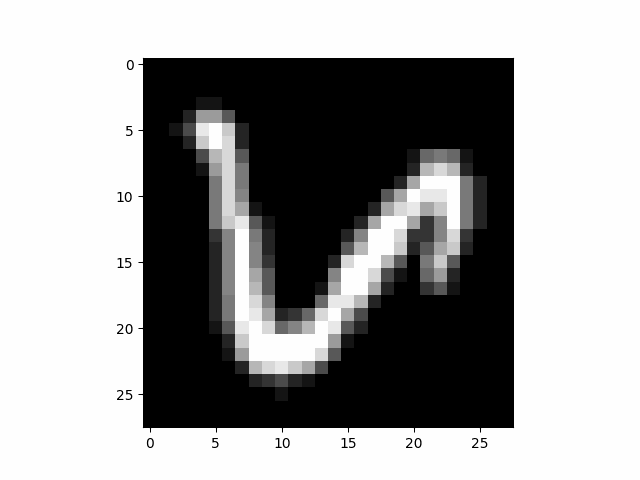

In [15]:
with open('diffusion.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [16]:
def save(ckpt_dir: str, state) -> None:
  with open(os.path.join(ckpt_dir, "arrays.npy"), "wb") as f:
    for x in jax.tree_leaves(state):
         np.save(f, x, allow_pickle=False)
    tree_struct = jax.tree_map(lambda t: 0, state)
  with open(os.path.join(ckpt_dir, "tree.pkl"), "wb") as f:
     pickle.dump(tree_struct, f)

def restore(ckpt_dir):
  with open(os.path.join(ckpt_dir, "tree.pkl"), "rb") as f:
    tree_struct = pickle.load(f)
 
  leaves, treedef = jax.tree_flatten(tree_struct)
  with open(os.path.join(ckpt_dir, "arrays.npy"), "rb") as f:
    flat_state = [np.load(f) for _ in leaves]

  return jax.tree_unflatten(treedef, flat_state)

In [20]:
from copy import deepcopy
import pickle
import sys

batches_iter = 10000

def train_model(opt_state, params, avg_params, model_name, train_new_model=False, energy_method=False):
    best_loss = sys.float_info.max # initialization
        
    if train_new_model or not os.path.exists(osp.join(model_paths, model_name + '.pt')):
        key = jax.random.PRNGKey(42)
        subkeys = jax.random.split(key, batches_iter)
        # sequence = np.stack([random.normal(subkey) for subkey in subkeys])
        losses = []
        for iteration in range(0, batches_iter):
            data_in_batch, label = next(train)
            data_in_batch = normalize(data_in_batch)
            label_one_hot = jax.nn.one_hot(label, 62)
            idx = jnp.multiply(jax.random.uniform(key=subkeys[iteration], shape=(batch_size, 1)), timesteps-1).astype(int)
            idx = einops.rearrange(idx, 'a b -> (a b)')
            timestep = idx + 1
            data_noisy, noise = get_noisy(data_in_batch, timestep)
            # todo: call gradient update function here
            loss_value, params, opt_state = update(params, opt_state, [data_in_batch, label_one_hot, timestep, noise])
            avg_params = ema_update(params, avg_params)
            
            if iteration % 10 == 0:                
                ## evaluating noise on a fixed timestep to calculate best model
                one_timestep = jnp.arange(1, batch_size+1)
                data_noisy_temp, noise_temp = get_noisy(data_in_batch, one_timestep)
                loss_temp = jax.device_get(compute_loss(params, [data_in_batch, label_one_hot, one_timestep, noise_temp]))
                losses.append(loss_temp)
                print('batch loss value', loss_value)
            
                if loss_temp < best_loss:
                    best_loss = loss_temp
                    print(f"saving iteration * batch_size: {iteration*batch_size} loss: {best_loss:>7f}")
                    # torch.save(deepcopy(denoising_model.state_dict()), osp.join(model_paths, model_name + '.pt'))
                    # write_cached([data_noisy, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))
            
                if iteration % 1000 == 0:
                    print(f"iteration * batch_size: {iteration*batch_size} loss: {loss_temp:>7f}")

    # if os.path.exists(osp.join(model_paths, model_name + '.pt')):
    #     # denoising_model.load_state_dict(torch.load(osp.join(model_paths, model_name + '.pt')))
    #     data_noisy, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
    return data_noisy, data_in_batch, timestep, losses, params, avg_params

In [ ]:
data_noisy, data_in_batch, timestep, losses, params, avg_params = train_model(opt_state, params, avg_params, 'emnist.jax_version', train_new_model= (train_new_model | generate_new_data), energy_method=False)
plt.plot(torch.Tensor(losses))

batch loss value 713.5409
saving iteration * batch_size: 0 loss: 1531.396118
iteration * batch_size: 0 loss: 1531.396118
batch loss value 622.2608
saving iteration * batch_size: 2560 loss: 1056.705322
batch loss value 739.8969
saving iteration * batch_size: 5120 loss: 1056.401733
batch loss value 687.42236
saving iteration * batch_size: 7680 loss: 1056.272949
batch loss value 708.3503
saving iteration * batch_size: 10240 loss: 1056.229980
batch loss value 702.1011
saving iteration * batch_size: 12800 loss: 1056.080811
batch loss value 594.46655
batch loss value 701.754
saving iteration * batch_size: 17920 loss: 1056.020996
batch loss value 713.4814
saving iteration * batch_size: 20480 loss: 1055.988647


In [ ]:
a, b = jnp.ones((100, 28, 28, 1)), jnp.ones((batch_size))
# b = einops.rearrange(b, 'a b -> (a b)')
jnp.multiply(timesteps, jnp.sum(a, axis=(1, 2, 3))).shape
# timestep = timesteps_
# jnp.sqrt(1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep])))

# huber_loss(jnp.ones((100,28,28,1)), jnp.ones((100,28,28,1))).shape

In [ ]:
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = jnp.exp(log_posterior_variance)

strided_schedule = list(range(1, timesteps, 4)) + [199]

alphas_strided_ = alphas_[strided_schedule]
alphas_prev_strided_ = jnp.pad(alphas_strided_[:-1], [1, 0], "constant", 1.0)

betas_strided = 1 - (alphas_strided_/alphas_prev_strided_)
posterior_variance_new_schedule = betas_strided * (1 - alphas_prev_strided_)/ (1-alphas_strided_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance_new_schedule[1], posterior_variance_new_schedule[1:]]))
posterior_variance_new_schedule_corrected = jnp.exp(log_posterior_variance)

In [ ]:
mean_coeff_1 = jnp.sqrt(1-betas_strided)*(1 - alphas_prev_strided_) / (1 - alphas_strided_)
mean_coeff_2 = jnp.sqrt(alphas_prev_strided_) * betas_strided / (1 - alphas_strided_)

def generate_data(denoising_model, tt=timesteps, energy_method=False, clipped_version=False, labels=None):
    # final_step_data = get_noisy(data_transformed, timesteps-1)
    # mean_last_step = torch.mean(final_step_data, dim=1)
    # std_last_step = torch.std(final_step_data, dim=1)
    batch_size_generation = 1
    # (tensor([0.4086, 0.4253]), tensor([-0.6379,  0.0137])))
     key = random.PRNGKey(42)
    # need to generate new keys everytime
    data_noisy = jax.random.normal(key, shape=(batch_size_generation, 28, 28, 1))
    
    if not labels:
      labelled_values = torch.zeros((62, batch_size_generation))
    elif labels=="circles":
      labelled_values = torch.vstack([torch.ones(batch_size_generation), torch.zeros(batch_size_generation)])
    elif labels=="moon":
      labelled_values = torch.vstack([torch.zeros(batch_size_generation), torch.ones(batch_size_generation)])
    elif labels=="mixed":
      batch_size_generation_ = int(batch_size_generation/2)
      labelled_values_1 = torch.vstack([torch.ones(batch_size_generation_), torch.zeros(batch_size_generation_)])
      labelled_values_2 = torch.vstack([torch.zeros(batch_size_generation_), torch.ones(batch_size_generation_)])
      labelled_values = torch.hstack([labelled_values_1, labelled_values_2])
      
    datas = []
    datas.append(torch.vstack([data_noisy.cpu().detach(), labelled_values]))
    for n in range(1, int(len(data_noisy[0])/batch_size_generation) + 1):
        data_in_batch = data_noisy[:, (n-1)*batch_size_generation:(n*batch_size_generation)]
        for t in range(1, len(strided_schedule)+1):
            timestep = strided_schedule[len(strided_schedule)-t]
            t_repeated = torch.Tensor([timestep]).repeat(batch_size_generation)
            data_stacked = torch.vstack([data_in_batch, labelled_values])
            pred_data = denoising_model(data_stacked.T, t_repeated)
            if not clipped_version:
                if not energy_method:
                    # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                    multiplier = torch.exp(torch.log((betas[timestep])) - torch.log(sd[timestep]))
                    mean_data = (data_in_batch.T.sub(pred_data.mul(multiplier))).div(torch.sqrt(alphas[timestep]))
                else:
                    ##
                    # Energy function interpretation
                    mean_data = (data_in_batch.T.add(pred_data.mul((betas[timestep])))).div(torch.sqrt(alphas[timestep]))
                    ##
            else:
                # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
                # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
                if not energy_method:
                    x_reconstructed = data_in_batch.T.sub(pred_data.mul(sd[timestep])).div(torch.sqrt(alphas_[timestep]))
                    if timestep >= 5:
                        x_reconstructed = torch.clip(x_reconstructed, -1., 1.)
                else:
                    # energy method and clipping to improve stabalization
                    x_reconstructed = data_in_batch.T.add(pred_data.mul(variance[timestep])).div(torch.sqrt(alphas_[timestep]))
                    if timestep >= 5:
                        x_reconstructed = torch.clip(x_reconstructed, -1., 1.)
                
                mean_data_1 = data_in_batch.T.mul(mean_coeff_1[len(strided_schedule)-t])
                mean_data_2 = x_reconstructed.mul(mean_coeff_2[len(strided_schedule)-t])
                mean_data = mean_data_1.add(mean_data_2)
                    
                

            posterior_data = posterior_variance_new_schedule_corrected[len(strided_schedule)-t]
            data_in_batch = torch.normal(mean_data, torch.sqrt(posterior_data)).T
            datas.append(torch.vstack([data_in_batch.cpu().detach(), labelled_values]))
    return datas, data_in_batch

In [ ]:
datas, data_in_batch = generate_data(denoising_model, tt, energy_method=True, clipped_version=True, labels="mixed")

In [ ]:
import imageio 
from IPython.display import Image

def print_gif(datas, name, color=False):
  filenames = []
  for i in range(0, len(datas)-20, 10):
    # plot the line chart
    if color:
      plt.scatter(datas[i][0], datas[i][1], c=datas[i][2]+ 2*datas[i][3])
    else:  
      plt.scatter(datas[i][0], datas[i][1])
    plt.ylim(-1,1)
    plt.xlim(-1, 1)

    # create file name and append it to a list
    filename = f'para-{i}.png'
    filenames.append(filename)

    # save frame
    plt.savefig(filename)
    plt.close()
    
  for j in range(len(datas)-20, len(datas)-1, 1):
    # plot the line chart
    if color: 
      plt.scatter(datas[j][0], datas[j][1], c=datas[j][2]+ 2*datas[j][3])
    else:
      plt.scatter(datas[j][0], datas[j][1])
    plt.ylim(-1,1)
    plt.xlim(-1, 1)

    # create file name and append it to a list
    filename = f'para-{i+j}.png'
    filenames.append(filename)

    # save frame
    plt.savefig(filename)
    plt.close()

  images = list(map(lambda filename: imageio.imread(filename), filenames))
      
  imageio.mimsave(os.path.join(name), images, fps=3) # modify the frame duration as needed

  # Remove files
  for filename in set(filenames):
      os.remove(filename)
  with open(name,'rb') as f:
    display(Image(data=f.read(), format='png'))
  
print_gif(datas, 'gifs/class_conditioned_no_labels.gif')

In [ ]:
print_gif(datas, 'gifs/class_conditioned_mixed_few_shot_position_embeddings_fast.gif', color=True)

_, (ax5, ax6, ax7) = plt.subplots(3)
tt= len(datas)

ax5.scatter(datas[tt - 25][0], datas[tt - 25][1])
ax6.scatter(datas[tt - 12][0], datas[tt - 12][1])
ax7.scatter(datas[tt - 1][0], datas[tt - 1][1])